In [68]:
import pandas as pd
import seaborn as sns
import json

sns.set_theme()

f = open("/var/home/marty/Documents/uni/fit-vut/bachelors-thesis/sysrapl/src/gnome-shell-profile2.json", mode="r")
data = json.load(f)
rapl_df = pd.DataFrame(data["rapl"])
syscall_df = pd.DataFrame(data["syscalls"])

print(syscall_df)

         id        name  cpu      tid       entry_time        exit_time  \
0        47     recvmsg    3  1790009  487448214896142  487448214899635   
1         1       write    3  1790009  487448214925376  487448214927232   
2       232  epoll_wait    3  1790009  487448214931057  487448214932658   
3        47     recvmsg    3  1790009  487448214935401  487448214941200   
4        16       ioctl    3  1790009  487448215046556  487448215053826   
...     ...         ...  ...      ...              ...              ...   
295627    0        read    1  1790009  487578553293269  487578553294159   
295628    0        read    1  1790009  487578553295523  487578553296092   
295629   47     recvmsg    1  1790009  487578553309351  487578553310212   
295630   47     recvmsg    1  1790009  487578553375820  487578553376889   
295631   46     sendmsg    1  1790009  487578553384715  487578553391511   

        duration     cores       pkg       ram      gpu       psys  
0           3493  61035156  85

In [69]:
syscall_df[["id", "cpu", "tid"]] = syscall_df[
    ["id", "cpu", "tid"]
].apply(pd.to_numeric, downcast="unsigned")

syscall_df[["entry_time", "exit_time"]] = syscall_df[
    ["entry_time", "exit_time"]
].apply(pd.to_datetime)

# Clean up the dataframe
syscall_df = syscall_df.drop(columns=["id", "cpu", "tid", "exit_time", "duration"])

syscall_df = syscall_df.set_index("name")

print(syscall_df)

                              entry_time     cores       pkg       ram  \
name                                                                     
recvmsg    1970-01-06 15:24:08.214896142  61035156  85693359  27832031   
write      1970-01-06 15:24:08.214925376  61035156  85693359  27832031   
epoll_wait 1970-01-06 15:24:08.214931057  61035156  85693359  27832031   
recvmsg    1970-01-06 15:24:08.214935401  61035156  85693359  27832031   
ioctl      1970-01-06 15:24:08.215046556  61035156  85693359  27832031   
...                                  ...       ...       ...       ...   
read       1970-01-06 15:26:18.553293269         0         0         0   
read       1970-01-06 15:26:18.553295523         0         0         0   
recvmsg    1970-01-06 15:26:18.553309351         0         0         0   
recvmsg    1970-01-06 15:26:18.553375820         0         0         0   
sendmsg    1970-01-06 15:26:18.553384715         0         0         0   

                gpu       psys  
name

In [70]:
wdf = syscall_df.groupby(by=["name"]).sum()

top_syscalls_df = (wdf
    .sort_values(by=["psys", "cores", "pkg", "ram", "gpu"], ascending=False)
    .head(n=5))
top_syscalls = top_syscalls_df.index.to_list()

print(top_syscalls)

['write', 'poll', 'recvmsg', 'read', 'ioctl']


/tmp/ipykernel_2825482/1655720054.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wdf = syscall_df.groupby(by=["name"]).sum()


In [71]:
def iqr(df: pd.DataFrame, column: str) -> pd.DataFrame:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    new_df = df.query(f'(@q1 - 1.5 * @iqr) <= {column} <= (@q3 + 1.5 * @iqr)')

    return new_df

def norm(df: pd.DataFrame, column: str) -> pd.DataFrame:
    min = df[column].min()
    max = df[column].max()

    df[column] = (df[column] - min) / (max - min) 
    return df

In [72]:
wdf1 = wdf

# Use values from q2 and q3
for domain in ["cores", "pkg", "ram", "gpu", "psys"]:
    wdf1 = iqr(wdf1, domain)

print(wdf1)

                         cores          pkg          ram         gpu  \
name                                                                   
close              38163757362  48446960369  14326599101  3328918480   
epoll_wait         56732666003  74222900376  21979003913  4728515622   
fchmod                 8178711     20812988     12939453           0   
fchown                 8178711     20812988     12939453           0   
fcntl              31207336433  38850646940  11113525369  2644897451   
getrusage           1147094725   1440979005    441528321           0   
inotify_add_watch   5122802740   7258789056   3013671864   114746096   
lseek               1834655764   2592285155    831909179   365295410   
madvise             1903625488   2494018557    743225097           0   
mmap               51708313020  67069946237  19657775919  5403686529   
munmap             51003173866  63724121087  17704772944  3953674223   
newfstatat         59253479030  74718444792  22630371065  343164

In [73]:
import scipy
import numpy

wdf2 = syscall_df
wdf2 = wdf2.reset_index()

# Keep in the list only the top consuming syscalls
wdf2 = wdf2[wdf2['name'].isin(top_syscalls) == True]
wdf2 = wdf2.reset_index().drop(columns="index")

# Resample the data to control the density
wdf2 = wdf2.set_index("entry_time").groupby("name").resample("1000ms").sum(numeric_only=True).reset_index()
wdf2 = wdf2.set_index("entry_time").groupby("name").resample("10ms").asfreq().drop(columns=["name"]).reset_index()
for domain in ["cores", "pkg", "ram", "gpu", "psys"]:
    wdf2[domain] = wdf2.groupby("name")[domain].transform(lambda g: g.interpolate(method="akima"))
    # Replace negative values with zeroes
    wdf2[domain] = wdf2[domain].clip(lower=0)

print(wdf2)

# wdf1 = wdf1.fillna(0)
# wdf1 = wdf1.interpolate(method="pad")

# for domain in ["cores", "pkg", "ram", "gpu", "psys"]:
#   wdf1[domain] = wdf1.groupby('name')[domain].transform(lambda x: x.ewm(com=0.5).mean())

#wdf = wdf.set_index("entry_time").groupby("name").resample("1ms").asfreq().drop(columns="name").reset_index()
#for domain in ["cores", "pkg", "ram", "gpu", "psys"]:
#    wdf[domain] = wdf.groupby("name")[domain].apply(lambda group: group.interpolate(method='akima'))
# wdf1 = wdf1.T.reset_index(drop=True)  # transpose dataframe
#wdf1 = wdf1.groupby("name").transform(pd.DataFrame.reindex, wdf1.index.union(pd.np.linspace(wdf1.index.min(),wdf1.index.max(), wdf1.index.shape[0]*10)))
#wdf1 = wdf1.interpolate('pchip', order=2)  # fill the gaps with values

# print(wdf2)

        name              entry_time         cores           pkg  \
0      ioctl 1970-01-06 15:24:08.000  9.436645e+08  1.302368e+09   
1      ioctl 1970-01-06 15:24:08.010  7.124735e+08  1.017182e+09   
2      ioctl 1970-01-06 15:24:08.020  4.873379e+08  7.394141e+08   
3      ioctl 1970-01-06 15:24:08.030  2.682125e+08  4.690087e+08   
4      ioctl 1970-01-06 15:24:08.040  5.505175e+07  2.059105e+08   
...      ...                     ...           ...           ...   
64900  write 1970-01-06 15:26:17.960  0.000000e+00  0.000000e+00   
64901  write 1970-01-06 15:26:17.970  0.000000e+00  0.000000e+00   
64902  write 1970-01-06 15:26:17.980  0.000000e+00  0.000000e+00   
64903  write 1970-01-06 15:26:17.990  0.000000e+00  0.000000e+00   
64904  write 1970-01-06 15:26:18.000  6.469726e+08  1.208496e+09   

                ram           gpu          psys  
0      4.164429e+08  7.177734e+07  2.844727e+09  
1      3.394455e+08  6.139631e+07  2.260059e+09  
2      2.644155e+08  5.127127e+07

In [74]:
wdf = wdf2

# Melt the columns into a structure the plotting library understands
wdf = wdf.melt(id_vars=["name", "entry_time"], value_vars=["cores", "pkg", "ram", "gpu", "psys"])

# Group together the name of syscalls and energy domains
wdf["group"] = wdf["name"] + "-" + wdf["variable"]
wdf = wdf.drop(columns=["name","variable"])

# Normalize values to (0,1) range
wdf = norm(wdf, "value")
wdf = wdf.fillna(0)

# Order from the highest consumption to the lowest
sort_order = wdf.groupby("group")["value"].max().sort_values(ascending=False).index.to_list()
wdf = wdf.sort_values(by="group", key=lambda column: column.map(lambda elem: sort_order.index(elem)))

print(wdf)

                    entry_time     value       group
324524 1970-01-06 15:26:18.000  0.003796  write-psys
315862 1970-01-06 15:24:51.380  0.009371  write-psys
315861 1970-01-06 15:24:51.370  0.008941  write-psys
315860 1970-01-06 15:24:51.360  0.008518  write-psys
315859 1970-01-06 15:24:51.350  0.008102  write-psys
...                        ...       ...         ...
216479 1970-01-06 15:25:36.630  0.000003    poll-gpu
216478 1970-01-06 15:25:36.620  0.000003    poll-gpu
216477 1970-01-06 15:25:36.610  0.000003    poll-gpu
216487 1970-01-06 15:25:36.710  0.000002    poll-gpu
207817 1970-01-06 15:24:10.010  0.001447    poll-gpu

[324525 rows x 3 columns]


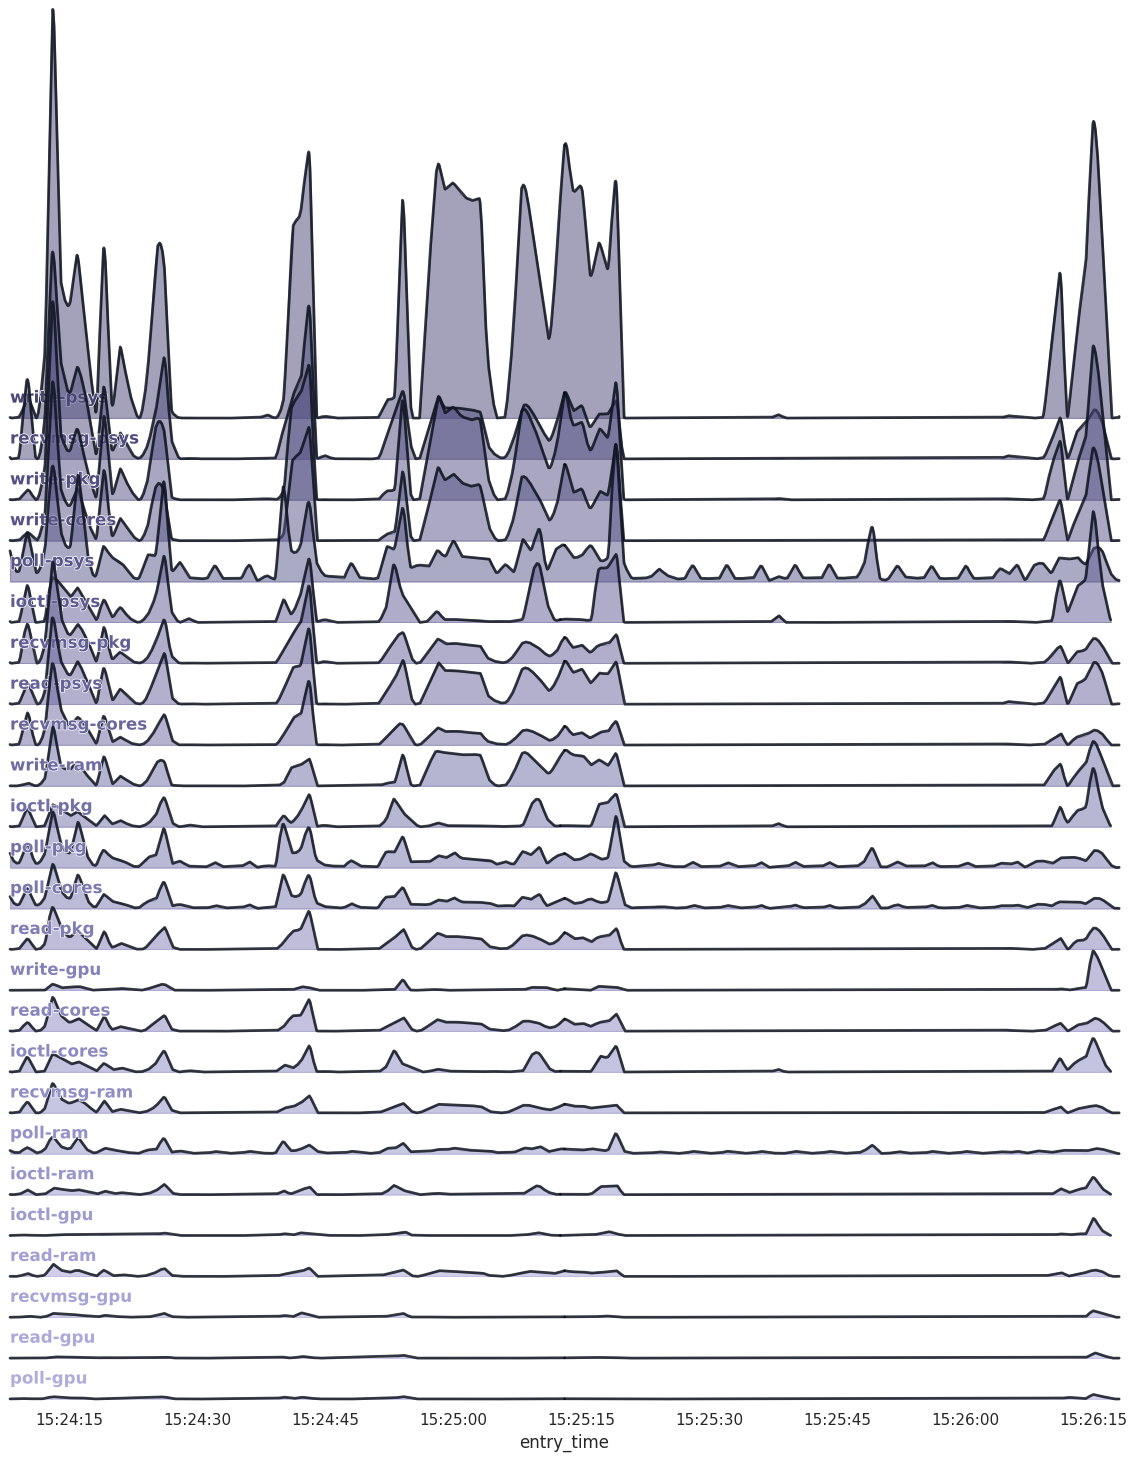

In [86]:
import matplotlib as mpl
import matplotlib.patheffects as mplpatheffects
import matplotlib.style as mplstyle
import matplotlib.transforms as mpltransforms
import matplotlib.pyplot as plt

# Just to increase the speed of plot rendering
mplstyle.use('fast')
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000

def draw_subplot(data, color, label, **kwargs):
  ax: plt.Axes = sns.lineplot(data=data, x="entry_time", y="value", hue="group", clip_on=False, alpha=0.5, lw=1.5, color=color, **kwargs)
  ax.margins(0)

  # Fill under the line
  line: plt.Line2D = ax.lines[0]
  ax.fill_between(line.get_xdata(), line.get_ydata(), color=color, alpha=0.5, **kwargs)

  # Outline to separate the diffeerent plots
  sns.lineplot(data=data, x="entry_time", y="value", clip_on=False, color="black", alpha=0.7, lw=2, **kwargs)

def draw_labels(data, color, label, **kwargs):
  ax: plt.Axes = plt.gca()

  txt: mpl.text = ax.text(0, 0.05, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)
  txt.set_path_effects([mplpatheffects.Stroke(linewidth=1, foreground='w'), mplpatheffects.Normal()])

groups: list[str] = wdf["group"].to_list()

with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
  pal: mpl.colors.ListedColormap = sns.cubehelix_palette(25, rot=0, dark=0.3, light=0.7, reverse=True)

  g: sns.FacetGrid = sns.FacetGrid(wdf, row="group", hue="group", aspect=20, height=0.6, sharex=True, legend_out=True, palette=pal, despine=True)
  g.map_dataframe(draw_subplot)
  g.map(draw_labels, "entry_time")
  
  g.set_titles("")
  g.set(yticks=[], ylabel="")
  g.despine(bottom=True, left=True)
  g.figure.subplots_adjust(hspace=-.90)